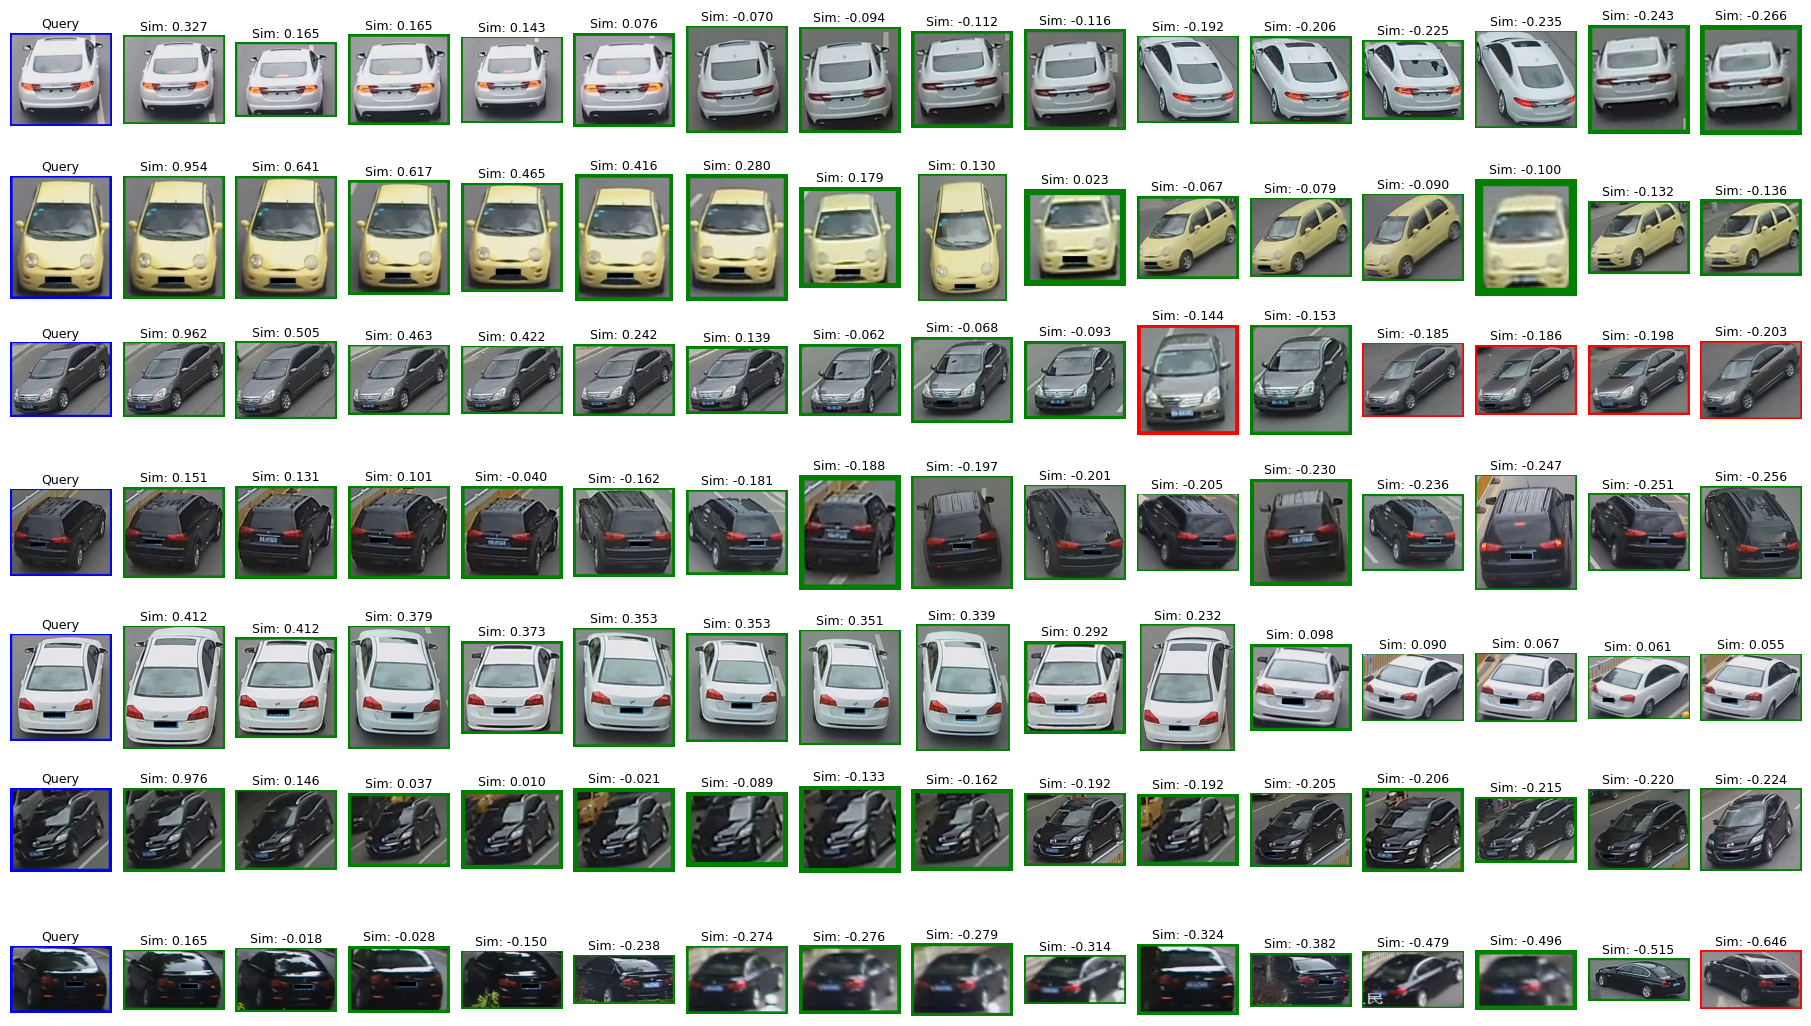

In [2]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil

def visualize_results(
    result_dir: str,
    image_folder: str,
    top_k: int = 10,
    border_width: int = 5,
    fig_width: int = 18,
    fig_height_per_query: float = 1.5
):
    """Visualize all queries in vertical layout with matches horizontally
    
    Args:
        result_dir: Directory containing evaluation results
        image_folder: Folder containing all images
        top_k: Number of top matches to show per query
        border_width: Width of border in pixels
        fig_width: Total figure width in inches
        fig_height_per_query: Figure height per query row in inches
    """
    with open('../dataset/VeRi/original_veri_query_list.txt') as f:
        query_files = [line.strip() for line in f.readlines()]
    with open('../dataset/VeRi/original_veri_test_list.txt') as f:
        gallery_files = [line.strip() for line in f.readlines()]
    
    # Find all sample files
    sample_files = sorted([f for f in os.listdir(result_dir) if f.startswith('sample_')])
    num_queries = len(sample_files)
    
    # Create figure with one column of queries
    fig = plt.figure(figsize=(fig_width, fig_height_per_query * num_queries),
                     constrained_layout=True)
    
    # Create main grid - one row per query
    grid = plt.GridSpec(num_queries, 1, figure=fig, hspace=0.5)
    
    for query_num, sample_file in enumerate(sample_files):
        # Load sample data
        with open(os.path.join(result_dir, sample_file), 'rb') as f:
            sample = pickle.load(f)
        
        query_idx = sample['query_idx']
        order = sample['order'][:top_k]
        scores = sample['scores'][:top_k]
        matches = sample['matches'][:top_k]
        
        # Create subgrid for this query (1 row, 1+top_k columns)
        subgrid = grid[query_num, 0].subgridspec(1, top_k + 1, wspace=0.1)
        
        # Plot query image
        ax_query = fig.add_subplot(subgrid[0, 0])
        query_img_path = os.path.join(image_folder, query_files[query_idx])
        plot_image_with_border(ax_query, query_img_path, "Query", 'blue', border_width)
        
        # Plot matches
        for i, (gallery_idx, score, match) in enumerate(zip(order, scores, matches)):
            ax_match = fig.add_subplot(subgrid[0, i+1])
            gallery_img_path = os.path.join(image_folder, gallery_files[gallery_idx])
            color = 'green' if match else 'red'
            plot_image_with_border(ax_match, gallery_img_path, f"Sim: {score:.4f}", color, border_width)
    
    plt.savefig(os.path.join(result_dir, 'results_vertical.png'), bbox_inches='tight', dpi=150)
    plt.show()

def plot_image_with_border(ax, img_path, title, color, border_width):
    """Helper function to plot image with border on specified axis"""
    try:
        img = Image.open(img_path)
        img = np.array(img)
        
        if len(img.shape) == 2:  # Grayscale
            img = np.stack([img]*3, axis=-1)
        
        border_color = np.array(plt.cm.colors.to_rgb(color)) * 255
        
        if border_width > 0:
            img[:border_width, :] = border_color  # Top
            img[-border_width:, :] = border_color  # Bottom
            img[:, :border_width] = border_color  # Left
            img[:, -border_width:] = border_color  # Right
        
        ax.imshow(img)
        ax.set_title(title, fontsize=9, pad=4)
        ax.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")
        ax.imshow(np.zeros((100, 100, 3)))
        ax.set_title("Image not found", fontsize=9)
        ax.axis('off')

if __name__ == "__main__":
    visualize_results(
        result_dir='/home/fedchin/vehicle_reid_itsc2023/vis_results/eval_20250414_203839',
        image_folder='/home/fedchin/vehicle_reid_itsc2023/dataset/veri_images',
        top_k=15
    )